In [3]:
!pip install beautifulsoup4

In [4]:
!pip install scikit-learn matplotlib

In [5]:
!pip install torch torchvision torchaudio -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install emoji


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.1 MB/s eta 0:00:00


In [8]:
!pip install transformers


In [9]:
import os
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [10]:
from transformers import RobertaTokenizer, RobertaModel

In [52]:
df_train = pd.read_csv("/content/drive/MyDrive/go_emotions/data/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
df_dev = pd.read_csv("/content/drive/MyDrive/go_emotions/data/dev.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [54]:
df_train['classes_list'] = df_train['Class'].apply(lambda x: x.split(','))
df_train['classes_len'] = df_train['classes_list'].apply(lambda x: len(x))
df_dev['classes_list'] = df_dev['Class'].apply(lambda x: x.split(','))
df_dev['classes_len'] = df_dev['classes_list'].apply(lambda x: len(x))

In [55]:
with open('/content/drive/MyDrive/go_emotions/data/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [56]:
emotion_file = open("/content/drive/MyDrive/go_emotions/data/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [57]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [58]:
df_train['Emotions'] = df_train['classes_list'].apply(idx2class)
df_dev['Emotions'] = df_dev['classes_list'].apply(idx2class)

In [61]:
def EmotionMapping(emotion_list):
    map_list = []

    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')

    return map_list

In [62]:
df_train['Mapped Emotions'] = df_train['Emotions'].apply(EmotionMapping)
df_dev['Mapped Emotions'] = df_dev['Emotions'].apply(EmotionMapping)

In [63]:
df_train['anger'] = np.zeros((len(df_train),1))
df_train['disgust'] = np.zeros((len(df_train),1))
df_train['fear'] = np.zeros((len(df_train),1))
df_train['joy'] = np.zeros((len(df_train),1))
df_train['sadness'] = np.zeros((len(df_train),1))
df_train['surprise'] = np.zeros((len(df_train),1))
df_train['neutral'] = np.zeros((len(df_train),1))

df_dev['anger'] = np.zeros((len(df_dev),1))
df_dev['disgust'] = np.zeros((len(df_dev),1))
df_dev['fear'] = np.zeros((len(df_dev),1))
df_dev['joy'] = np.zeros((len(df_dev),1))
df_dev['sadness'] = np.zeros((len(df_dev),1))
df_dev['surprise'] = np.zeros((len(df_dev),1))
df_dev['neutral'] = np.zeros((len(df_dev),1))

In [64]:
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    df_train[i] = df_train['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    df_dev[i] = df_dev['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

In [67]:
df_train[:10]

,Text,ID,List of classes,Len of classes,anger,fear,joy,sadness,surprise
2,WHY THE FUCK IS BAYLESS ISOING,eezlygj,[2],1,1,0,0,0,0
3,To make her feel threatened,ed7ypvh,[14],1,0,1,0,0,0
4,Dirty Southern Wankers,ed0bdzj,[3],1,1,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,[26],1,0,0,0,0,1
6,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,[15],1,0,0,1,0,0
7,We need more boards and to create a bit more s...,ef4qmod,"[8, 20]",2,0,0,1,0,0
8,Damn youtube and outrage drama is super lucrat...,ed8wbdn,[0],1,0,0,1,0,0
10,Demographics? I don’t know anybody under 35 wh...,eel6g5h,[6],1,0,0,0,0,1
11,"Aww... she'll probably come around eventually,...",edex4ki,"[1, 4]",2,0,0,1,0,0
13,R/sleeptrain Might be time for some sleep trai...,efh7xnk,[5],1,0,0,1,0,0


In [68]:
df_dev[:10]

,Text,ID,List of classes,Len of classes,anger,fear,joy,sadness,surprise
2,I've never been this sad in my life!,edcu99z,[25],1,0,0,0,1,0
4,He could have easily taken a real camera from ...,eepig6r,[20],1,0,0,1,0,0
5,"Thank you for your vote of confidence, but we ...",eczm50f,[15],1,0,0,1,0,0
6,Wah Mum other people call me on my bullshit an...,ed4yr9r,[2],1,1,0,0,0,0
8,At least now [NAME] has more time to gain his ...,eekez9p,[20],1,0,0,1,0,0
9,Good. We don't want more thrash liberal offspr...,ee0fxpu,[10],1,1,0,0,0,0
10,It's better to say a moment like that could tr...,eelgxk0,[18],1,0,0,1,0,0
11,I went to a destination wedding being the only...,eczyj0h,"[12, 22]",2,0,0,0,1,1
12,He died 4 days later of dehydration,edwloev,[16],1,0,0,0,1,0
14,Lol dream on buddy. You’ve had enough attentio...,ed2znun,"[1, 3, 25]",3,1,0,1,1,0


In [65]:
df_train.drop(df_train[df_train['neutral'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['neutral'] == 1].index, inplace=True)
df_train.drop(df_train[df_train['disgust'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['disgust'] == 1].index, inplace=True)

In [66]:
df_train.drop(['Class', 'classes_list', 'classes_len', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)
df_dev.drop(['Class', 'classes_list', 'classes_len', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)

In [25]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [26]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [27]:
# df_train['Text'] = df_train['Text'].apply(text_preprocessing_pipeline)
# df_dev['Text'] = df_dev['Text'].apply(text_preprocessing_pipeline)

In [28]:
df_train.reset_index(drop=True).to_csv("train.csv", index=False)
df_dev.reset_index(drop=True).to_csv("val.csv", index=False)

In [29]:
df_train = df_train.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)

In [69]:
df_train[:10]

,Text,ID,List of classes,Len of classes,anger,fear,joy,sadness,surprise
2,WHY THE FUCK IS BAYLESS ISOING,eezlygj,[2],1,1,0,0,0,0
3,To make her feel threatened,ed7ypvh,[14],1,0,1,0,0,0
4,Dirty Southern Wankers,ed0bdzj,[3],1,1,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,[26],1,0,0,0,0,1
6,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,[15],1,0,0,1,0,0
7,We need more boards and to create a bit more s...,ef4qmod,"[8, 20]",2,0,0,1,0,0
8,Damn youtube and outrage drama is super lucrat...,ed8wbdn,[0],1,0,0,1,0,0
10,Demographics? I don’t know anybody under 35 wh...,eel6g5h,[6],1,0,0,0,0,1
11,"Aww... she'll probably come around eventually,...",edex4ki,"[1, 4]",2,0,0,1,0,0
13,R/sleeptrain Might be time for some sleep trai...,efh7xnk,[5],1,0,0,1,0,0


In [31]:
print(df_train.shape)
print(df_dev.shape)

(28427, 7)
(3564, 7)


In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [34]:
target_cols = [col for col in df_train.columns if col not in ['Text', 'ID']]
target_cols

['anger', 'fear', 'joy', 'sadness', 'surprise']

In [35]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [36]:
train_dataset = BERTDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = BERTDataset(df_dev, tokenizer, MAX_LEN)

In [37]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=4, shuffle=False, pin_memory=True)

In [38]:

class ROBERTAClass(torch.nn.Module):
    def __init__(self):
        super(ROBERTAClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
#         self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,5)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = ROBERTAClass()
model.to(device);

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [40]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [41]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [42]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.7199791073799133
Epoch: 0, Loss:  0.18663623929023743
Epoch: 1, Loss:  0.18024055659770966
Epoch: 1, Loss:  0.21079067885875702
Epoch: 2, Loss:  0.20243732631206512
Epoch: 2, Loss:  0.134577676653862


In [43]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [44]:
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7724466891133558
F1 Score (Micro) = 0.8331326107319685
F1 Score (Macro) = 0.7694791267422139


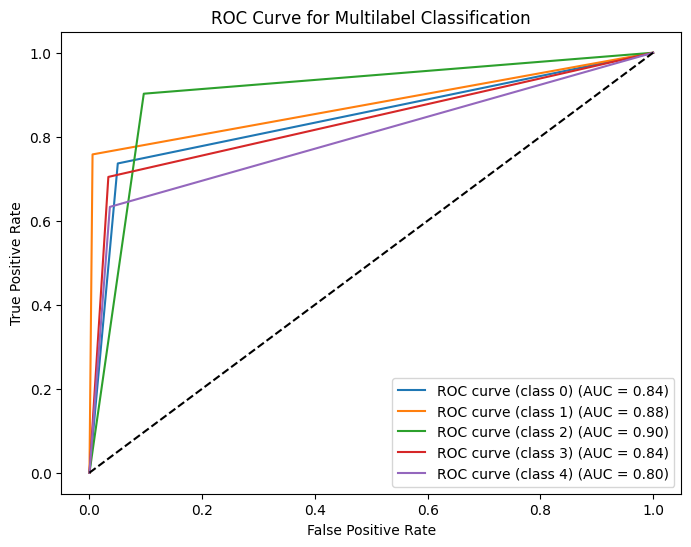

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to numpy arrays
targets = np.array(targets)
outputs = np.array(outputs)

# Compute ROC curve for each class
n_classes = targets.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets[:, i], outputs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multilabel Classification')
plt.legend(loc='best')
plt.show()


In [49]:
# Classification Report for RoBERTa
classification_report_roberta = metrics.classification_report(targets, outputs)
print("\nClassification Report for RoBERTa:")
print(classification_report_roberta)


Classification Report for RoBERTa:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       660
           1       0.79      0.76      0.77        95
           2       0.93      0.90      0.92      2132
           3       0.71      0.70      0.71       372
           4       0.77      0.63      0.70       583

   micro avg       0.86      0.81      0.83      3842
   macro avg       0.80      0.75      0.77      3842
weighted avg       0.86      0.81      0.83      3842
 samples avg       0.85      0.83      0.83      3842

